# CSIRO - Image2Biomass Prediction
## Predicting Pasture Biomass from Images

**Competition Goal:** Build a model that predicts pasture biomass (in grams) from images to help farmers make better grazing decisions.

**Targets to Predict:**
- `Dry_Green_g` (weight: 0.1)
- `Dry_Dead_g` (weight: 0.1)
- `Dry_Clover_g` (weight: 0.1)
- `GDM_g` (Green Dry Matter, weight: 0.2)
- `Dry_Total_g` (weight: 0.5)

**Evaluation Metric:** Weighted R² (coefficient of determination) with global weighting across all target-image pairs.

## 1. Import Libraries and Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetB0, EfficientNetV2B0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Check GPU availability
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

TensorFlow version: 2.20.0
GPU Available: []


In [2]:
# Define paths
DATA_PATH = r"D:\ML Practice\CSIRO - Image2Biomass Prediction\CSIRO - Image2Biomass Prediction"
TRAIN_IMG_PATH = os.path.join(DATA_PATH, 'train')
TEST_IMG_PATH = os.path.join(DATA_PATH, 'test')
TRAIN_CSV = os.path.join(DATA_PATH, 'train.csv')
TEST_CSV = os.path.join(DATA_PATH, 'test.csv')
SAMPLE_SUB = os.path.join(DATA_PATH, 'sample_submission.csv')

# Image parameters
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 100

# Target columns
TARGET_COLS = ['Dry_Green_g', 'Dry_Dead_g', 'Dry_Clover_g', 'GDM_g', 'Dry_Total_g']
WEIGHTS = {'Dry_Green_g': 0.1, 'Dry_Dead_g': 0.1, 'Dry_Clover_g': 0.1, 'GDM_g': 0.2, 'Dry_Total_g': 0.5}

print("Setup complete!")

Setup complete!


## 2. Load and Explore Data

In [8]:
# Load datasets
train_df_raw = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)
sample_sub = pd.read_csv(SAMPLE_SUB)

print("Raw Training Data Shape:", train_df_raw.shape)
print("\nRaw Training Data Info:")
print(train_df_raw.info())
print("\nFirst few rows:")
print(train_df_raw.head(10))

# Convert from long to wide format
# Extract image_id from image_path
train_df_raw['image_id'] = train_df_raw['image_path'].str.split('/').str[1].str.replace('.jpg', '')

# Pivot the data to get one row per image with all targets as columns
train_df = train_df_raw.pivot_table(
    index=['image_id', 'image_path', 'Sampling_Date', 'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm'],
    columns='target_name',
    values='target'
).reset_index()

# Flatten column names
train_df.columns.name = None

print("\n" + "="*60)
print("Transformed Training Data (Wide Format):")
print("="*60)
print("Shape:", train_df.shape)
print("\nColumns:", train_df.columns.tolist())
print("\nFirst few rows:")
train_df.head()

Raw Training Data Shape: (1785, 9)

Raw Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1785 entries, 0 to 1784
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sample_id      1785 non-null   object 
 1   image_path     1785 non-null   object 
 2   Sampling_Date  1785 non-null   object 
 3   State          1785 non-null   object 
 4   Species        1785 non-null   object 
 5   Pre_GSHH_NDVI  1785 non-null   float64
 6   Height_Ave_cm  1785 non-null   float64
 7   target_name    1785 non-null   object 
 8   target         1785 non-null   float64
dtypes: float64(3), object(6)
memory usage: 125.6+ KB
None

First few rows:
                    sample_id              image_path Sampling_Date State  \
0  ID1011485656__Dry_Clover_g  train/ID1011485656.jpg      2015/9/4   Tas   
1    ID1011485656__Dry_Dead_g  train/ID1011485656.jpg      2015/9/4   Tas   
2   ID1011485656__Dry_Green_g  train/ID1011

,image_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,Dry_Clover_g,Dry_Dead_g,Dry_Green_g,Dry_Total_g,GDM_g
0,ID1011485656,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,0.0000,31.9984,16.2751,48.2735,16.2750
1,ID1012260530,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,0.0000,0.0000,7.6000,7.6000,7.6000
2,ID1025234388,train/ID1025234388.jpg,2015/9/1,WA,SubcloverDalkeith,0.38,1.0000,6.0500,0.0000,0.0000,6.0500,6.0500
3,ID1028611175,train/ID1028611175.jpg,2015/5/18,Tas,Ryegrass,0.66,5.0000,0.0000,30.9703,24.2376,55.2079,24.2376
4,ID1035947949,train/ID1035947949.jpg,2015/9/11,Tas,Ryegrass,0.54,3.5000,0.4343,23.2239,10.5261,34.1844,10.9605


In [9]:
# Check for missing values
print("Missing Values in Training Data:")
print(train_df.isnull().sum())
print("\nBasic Statistics:")
train_df.describe()

Missing Values in Training Data:
image_id         0
image_path       0
Sampling_Date    0
State            0
Species          0
Pre_GSHH_NDVI    0
Height_Ave_cm    0
Dry_Clover_g     0
Dry_Dead_g       0
Dry_Green_g      0
Dry_Total_g      0
GDM_g            0
dtype: int64

Basic Statistics:


,Pre_GSHH_NDVI,Height_Ave_cm,Dry_Clover_g,Dry_Dead_g,Dry_Green_g,Dry_Total_g,GDM_g
count,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000
mean,0.657423,7.595985,6.649692,12.044548,26.624722,45.318097,33.274414
std,0.152142,10.285262,12.117761,12.402007,25.401232,27.984015,24.935822
min,0.160000,1.000000,0.000000,0.000000,0.000000,1.040000,1.040000
25%,0.560000,3.000000,0.000000,3.200000,8.800000,25.271500,16.026100
50%,0.690000,4.000000,1.423500,7.980900,20.800000,40.300000,27.108200
75%,0.770000,7.000000,7.242900,17.637800,35.083400,57.880000,43.675700
max,0.910000,70.000000,71.786500,83.840700,157.983600,185.700000,157.983600


In [10]:
# Check test data
print("Test Data Shape:", test_df.shape)
print("\nTest Data:")
print(test_df.head())
print("\nSample Submission Format:")
print(sample_sub.head(10))

Test Data Shape: (5, 3)

Test Data:
                    sample_id             image_path   target_name
0  ID1001187975__Dry_Clover_g  test/ID1001187975.jpg  Dry_Clover_g
1    ID1001187975__Dry_Dead_g  test/ID1001187975.jpg    Dry_Dead_g
2   ID1001187975__Dry_Green_g  test/ID1001187975.jpg   Dry_Green_g
3   ID1001187975__Dry_Total_g  test/ID1001187975.jpg   Dry_Total_g
4         ID1001187975__GDM_g  test/ID1001187975.jpg         GDM_g

Sample Submission Format:
                    sample_id  target
0  ID1001187975__Dry_Clover_g     0.0
1    ID1001187975__Dry_Dead_g     0.0
2   ID1001187975__Dry_Green_g     0.0
3   ID1001187975__Dry_Total_g     0.0
4         ID1001187975__GDM_g     0.0


## 3. Exploratory Data Analysis

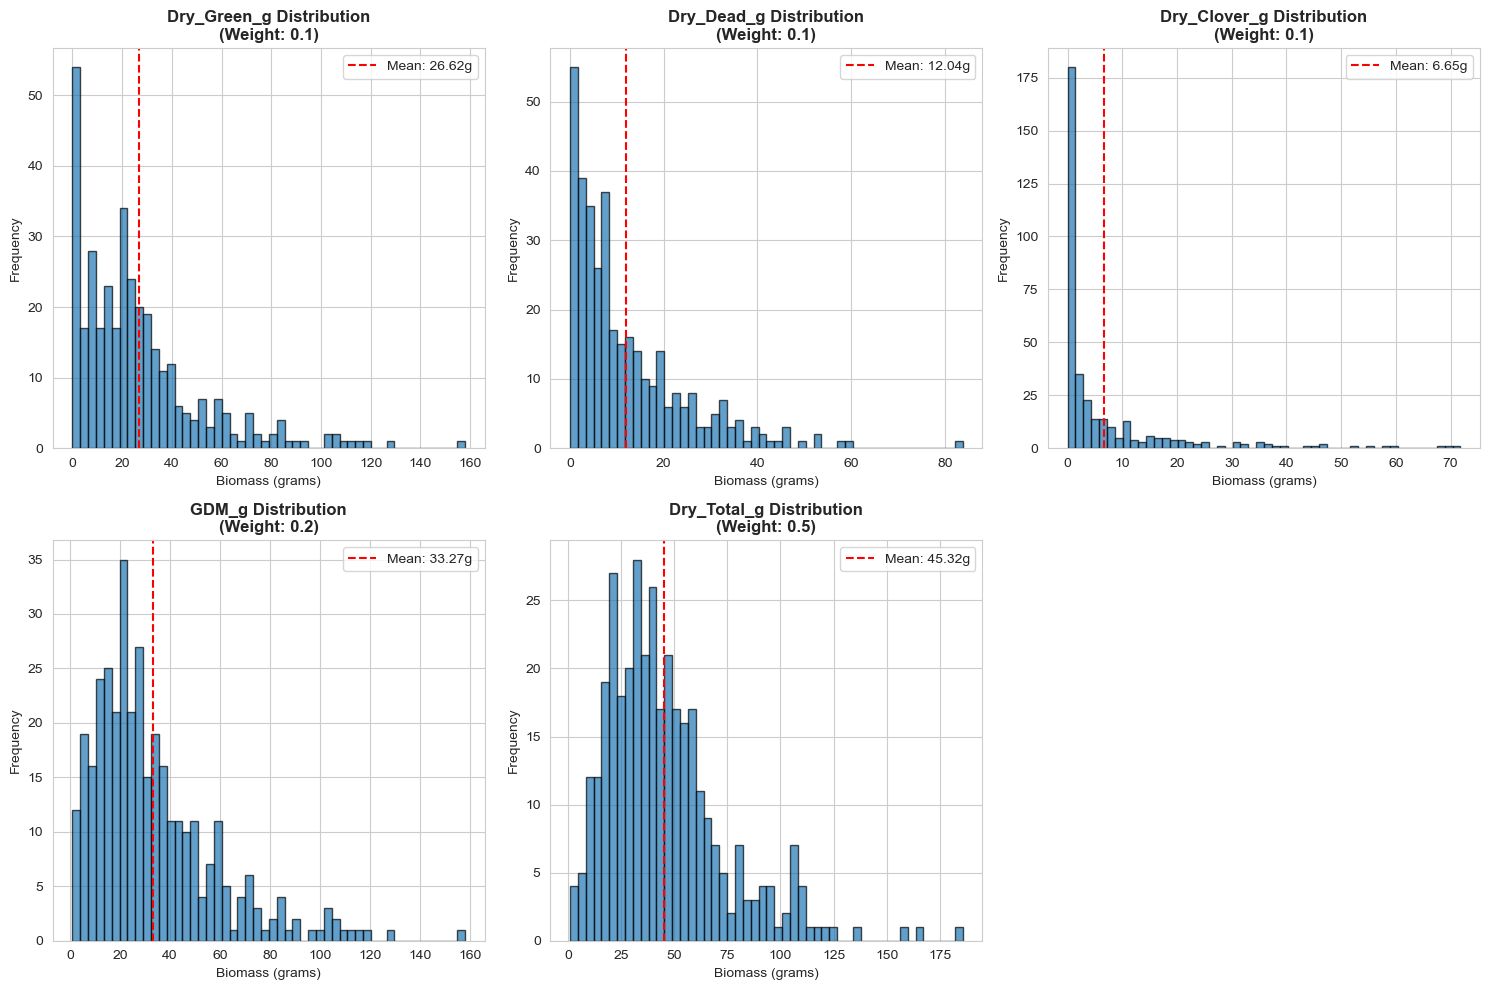


Target Statistics:
       Dry_Green_g  Dry_Dead_g  Dry_Clover_g       GDM_g  Dry_Total_g
count   357.000000  357.000000    357.000000  357.000000   357.000000
mean     26.624722   12.044548      6.649692   33.274414    45.318097
std      25.401232   12.402007     12.117761   24.935822    27.984015
min       0.000000    0.000000      0.000000    1.040000     1.040000
25%       8.800000    3.200000      0.000000   16.026100    25.271500
50%      20.800000    7.980900      1.423500   27.108200    40.300000
75%      35.083400   17.637800      7.242900   43.675700    57.880000
max     157.983600   83.840700     71.786500  157.983600   185.700000


In [11]:
# Visualize target distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, col in enumerate(TARGET_COLS):
    axes[idx].hist(train_df[col], bins=50, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{col} Distribution\n(Weight: {WEIGHTS[col]})', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Biomass (grams)')
    axes[idx].set_ylabel('Frequency')
    axes[idx].axvline(train_df[col].mean(), color='red', linestyle='--', label=f'Mean: {train_df[col].mean():.2f}g')
    axes[idx].legend()

# Remove extra subplot
fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

# Print statistics
print("\nTarget Statistics:")
print(train_df[TARGET_COLS].describe())

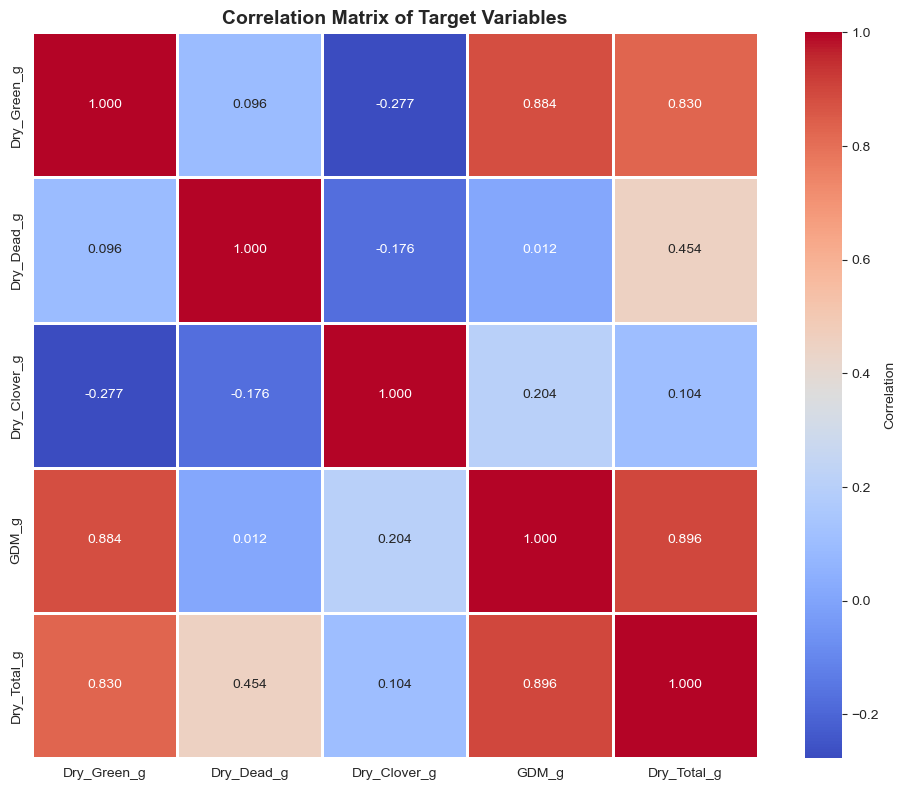


Key Insights:
- High correlations suggest the targets are related (expected)
- Dry_Total_g should be sum of components


In [12]:
# Correlation analysis
correlation_matrix = train_df[TARGET_COLS].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            square=True, cbar_kws={'label': 'Correlation'}, linewidths=1)
plt.title('Correlation Matrix of Target Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nKey Insights:")
print("- High correlations suggest the targets are related (expected)")
print("- Dry_Total_g should be sum of components")

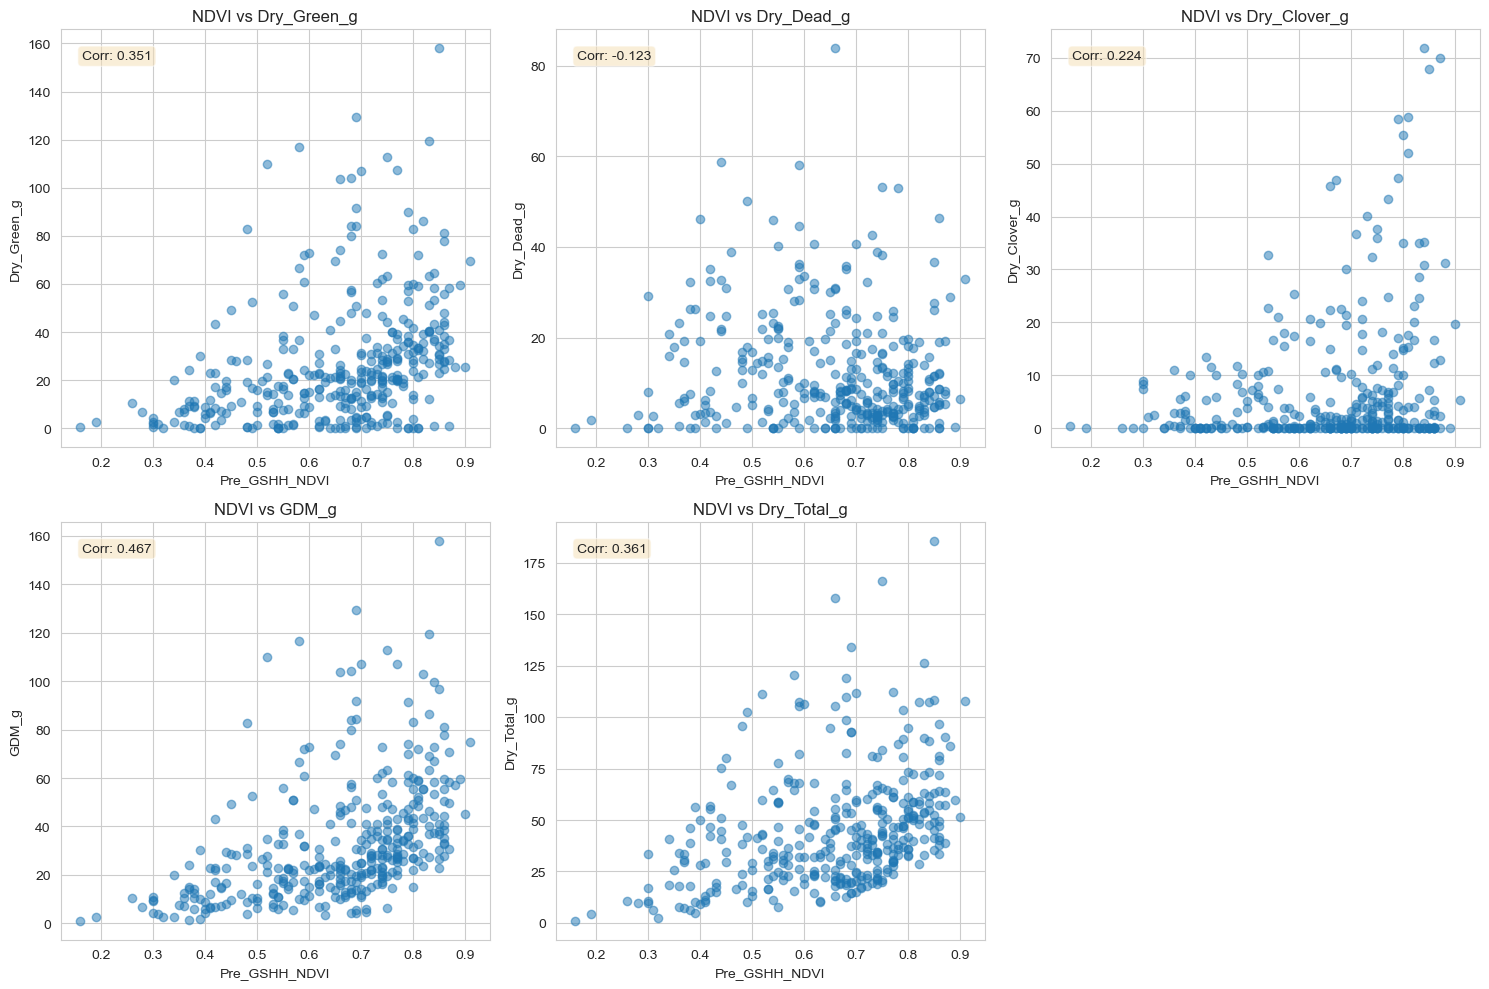

In [14]:
# Check NDVI correlation with targets if available
if 'Pre_GSHH_NDVI' in train_df.columns:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, col in enumerate(TARGET_COLS):
        axes[idx].scatter(train_df['Pre_GSHH_NDVI'], train_df[col], alpha=0.5)
        axes[idx].set_xlabel('Pre_GSHH_NDVI')
        axes[idx].set_ylabel(col)
        axes[idx].set_title(f'NDVI vs {col}')
        
        # Calculate correlation
        corr = train_df['Pre_GSHH_NDVI'].corr(train_df[col])
        axes[idx].text(0.05, 0.95, f'Corr: {corr:.3f}', 
                      transform=axes[idx].transAxes, 
                      verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    fig.delaxes(axes[5])
    plt.tight_layout()
    plt.show()
else:
    print("NDVI column not found in training data")

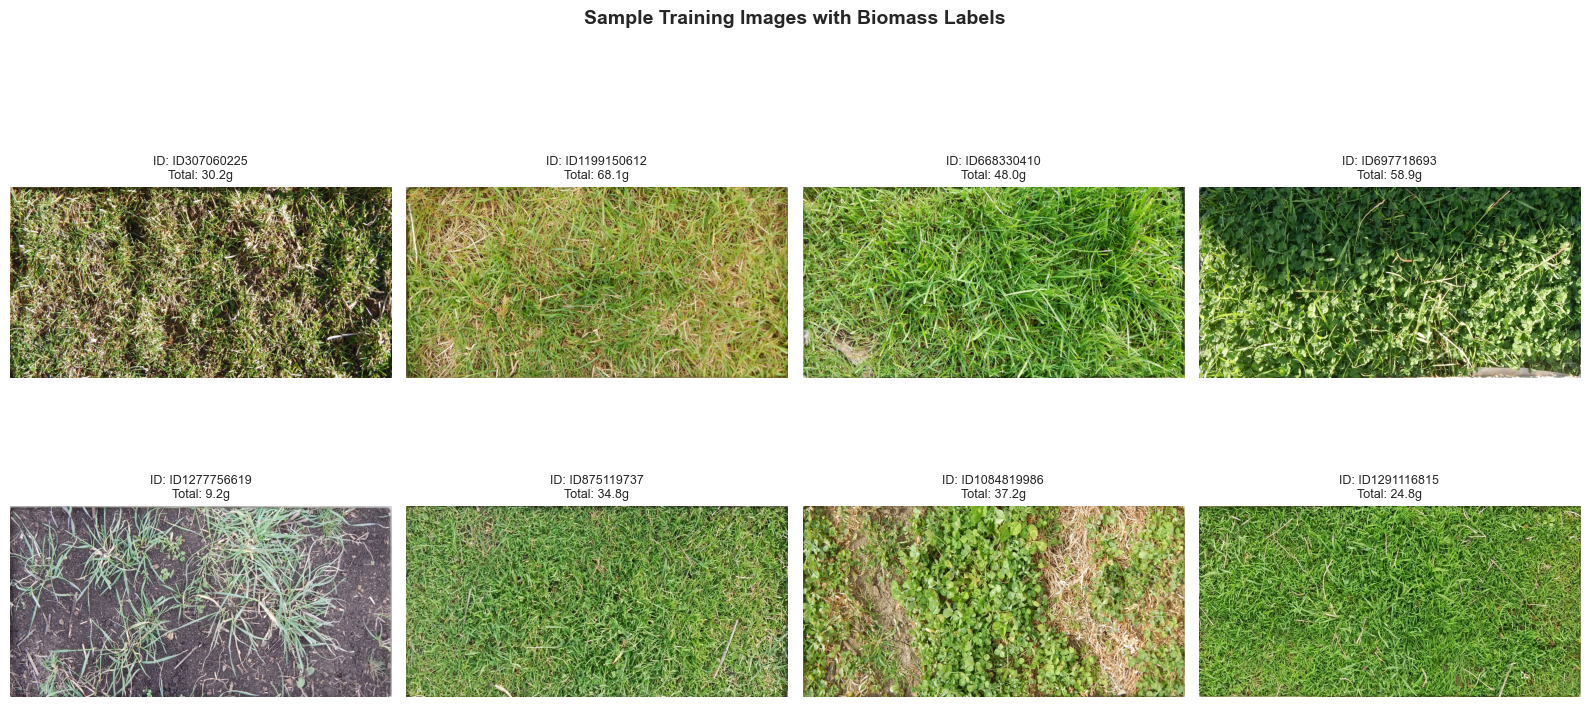

In [15]:
# Visualize sample images from training set
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

sample_images = train_df.sample(8, random_state=42)

for idx, (_, row) in enumerate(sample_images.iterrows()):
    img_path = os.path.join(TRAIN_IMG_PATH, f"{row['image_id']}.jpg")
    
    if os.path.exists(img_path):
        img = Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(f"ID: {row['image_id']}\nTotal: {row['Dry_Total_g']:.1f}g", fontsize=9)
    else:
        axes[idx].text(0.5, 0.5, 'Image not found', ha='center', va='center')
        axes[idx].axis('off')

plt.suptitle('Sample Training Images with Biomass Labels', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 4. Data Preparation and Image Loading

In [16]:
def load_and_preprocess_image(image_path, img_size=IMG_SIZE):
    """Load and preprocess image for model input"""
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_size, img_size])
    img = tf.cast(img, tf.float32) / 255.0  # Normalize to [0, 1]
    return img

def create_dataset(df, img_dir, is_training=True):
    """Create TensorFlow dataset from dataframe"""
    image_paths = [os.path.join(img_dir, f"{img_id}.jpg") for img_id in df['image_id']]
    
    if is_training:
        targets = df[TARGET_COLS].values.astype(np.float32)
        
        # Create dataset
        dataset = tf.data.Dataset.from_tensor_slices((image_paths, targets))
        dataset = dataset.map(lambda x, y: (load_and_preprocess_image(x), y), 
                            num_parallel_calls=tf.data.AUTOTUNE)
        
        if is_training:
            dataset = dataset.shuffle(1000)
        
        dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    else:
        # For test data without targets
        dataset = tf.data.Dataset.from_tensor_slices(image_paths)
        dataset = dataset.map(load_and_preprocess_image, 
                            num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    
    return dataset

print("Data loading functions created!")

Data loading functions created!


In [17]:
# Split data into train and validation sets
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_df)}")

# Create datasets
train_dataset = create_dataset(train_data, TRAIN_IMG_PATH, is_training=True)
val_dataset = create_dataset(val_data, TRAIN_IMG_PATH, is_training=True)

print("\nDatasets created successfully!")

Training samples: 285
Validation samples: 72
Test samples: 5

Datasets created successfully!


## 5. Build Multi-Output CNN Model

In [18]:
def build_biomass_model(img_size=IMG_SIZE, num_targets=5):
    """
    Build a CNN model using EfficientNetB0 as backbone
    Outputs 5 biomass predictions simultaneously
    """
    # Input layer
    inputs = layers.Input(shape=(img_size, img_size, 3))
    
    # Use EfficientNetB0 as feature extractor (pretrained on ImageNet)
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs,
        pooling='avg'
    )
    
    # Fine-tune the last few layers
    base_model.trainable = True
    for layer in base_model.layers[:-20]:
        layer.trainable = False
    
    # Get features from base model
    x = base_model.output
    
    # Add custom regression head
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation='relu')(x)
    
    # Output layer: 5 targets (all biomass values in grams)
    # Using linear activation for regression
    outputs = layers.Dense(num_targets, activation='linear', name='biomass_outputs')(x)
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs, name='BiomassPredictor')
    
    return model

# Build the model
model = build_biomass_model()
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


Model: "BiomassPredictor"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,870,312 (18.58 MB)

 Trainable params: 1,950,517 (7.44 MB)

 Non-trainable params: 2,919,795 (11.14 MB)

In [19]:
# Custom weighted R² metric for monitoring
class WeightedR2(keras.metrics.Metric):
    def __init__(self, name='weighted_r2', **kwargs):
        super().__init__(name=name, **kwargs)
        self.weights = tf.constant([0.1, 0.1, 0.1, 0.2, 0.5], dtype=tf.float32)
        self.ss_res = self.add_weight(name='ss_res', initializer='zeros')
        self.ss_tot = self.add_weight(name='ss_tot', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')
        self.weighted_mean = self.add_weight(name='weighted_mean', initializer='zeros')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Expand weights to match batch size
        batch_size = tf.shape(y_true)[0]
        weights_expanded = tf.tile(tf.expand_dims(self.weights, 0), [batch_size, 1])
        
        # Calculate weighted mean
        weighted_sum = tf.reduce_sum(y_true * weights_expanded)
        total_weight = tf.reduce_sum(weights_expanded)
        self.weighted_mean.assign(weighted_sum / total_weight)
        
        # Calculate residuals
        residuals = y_true - y_pred
        ss_res_batch = tf.reduce_sum(weights_expanded * tf.square(residuals))
        
        # Calculate total sum of squares
        deviations = y_true - self.weighted_mean
        ss_tot_batch = tf.reduce_sum(weights_expanded * tf.square(deviations))
        
        self.ss_res.assign_add(ss_res_batch)
        self.ss_tot.assign_add(ss_tot_batch)
        self.count.assign_add(1.0)
    
    def result(self):
        return 1.0 - (self.ss_res / (self.ss_tot + 1e-7))
    
    def reset_state(self):
        self.ss_res.assign(0.0)
        self.ss_tot.assign(0.0)
        self.count.assign(0.0)
        self.weighted_mean.assign(0.0)

print("Custom weighted R² metric created!")

Custom weighted R² metric created!


In [20]:
# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',  # Mean Squared Error for regression
    metrics=['mae', WeightedR2()]
)

print("Model compiled successfully!")

Model compiled successfully!


## 6. Train the Model

In [21]:
# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_biomass_model.h5',
        monitor='val_weighted_r2',
        mode='max',
        save_best_only=True,
        verbose=1
    )
]

print("Callbacks configured!")

Callbacks configured!


In [22]:
# Train the model
print("Starting model training...")
print(f"Training on {len(train_data)} samples")
print(f"Validating on {len(val_data)} samples")
print(f"Epochs: {EPOCHS}")
print("-" * 50)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

Starting model training...
Training on 285 samples
Validating on 72 samples
Epochs: 100
--------------------------------------------------
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 1102.0803 - mae: 22.2829 - weighted_r2: -1.0430
Epoch 1: val_weighted_r2 improved from None to -1.37734, saving model to best_biomass_model.h5

Epoch 1: val_weighted_r2 improved from None to -1.37734, saving model to best_biomass_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 255ms/step - loss: 834.2267 - mae: 19.0795 - weighted_r2: -0.4804 - val_loss: 983.6035 - val_mae: 21.9893 - val_weighted_r2: -1.3773 - learning_rate: 0.0010
Epoch 2/100
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 544.1484 - mae: 15.7432 - weighted_r2: 0.1145
Epoch 2: val_weighted_r2 improved from -1.37734 to -1.25714, saving model to best_biomass_model.h5

Epoch 2: val_weighted_r2 improved from -1.37734 to -1.25714, saving model to best_biomass_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - loss: 538.2045 - mae: 16.0351 - weighted_r2: 0.1249 - val_loss: 920.2812 - val_mae: 21.0308 - val_weighted_r2: -1.2571 - learning_rate: 0.0010
Epoch 3/100
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 476.6071 - mae: 14.4492 - weighted_r2: 0.1658
Epoch 3: val_weighted_r2 improved from -1.25714 to -0.60330, saving model to best_biomass_model.h5

Epoch 3: val_weighted_r2 improved from -1.25714 to -0.60330, saving model to best_biomass_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - loss: 535.4404 - mae: 15.6417 - weighted_r2: 0.1298 - val_loss: 686.2567 - val_mae: 17.3960 - val_weighted_r2: -0.6033 - learning_rate: 0.0010
Epoch 4/100
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 560.4112 - mae: 15.1520 - weighted_r2: 0.1535
Epoch 4: val_weighted_r2 improved from -0.60330 to -0.00001, saving model to best_biomass_model.h5

Epoch 4: val_weighted_r2 improved from -0.60330 to -0.00001, saving model to best_biomass_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - loss: 515.6156 - mae: 15.2634 - weighted_r2: 0.1619 - val_loss: 463.7043 - val_mae: 14.2982 - val_weighted_r2: -8.3447e-06 - learning_rate: 0.0010
Epoch 5/100
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 500.4919 - mae: 16.1048 - weighted_r2: 0.1640
Epoch 5: val_weighted_r2 improved from -0.00001 to 0.11483, saving model to best_biomass_model.h5

Epoch 5: val_weighted_r2 improved from -0.00001 to 0.11483, saving model to best_biomass_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - loss: 516.1078 - mae: 15.6904 - weighted_r2: 0.1720 - val_loss: 426.5953 - val_mae: 13.8145 - val_weighted_r2: 0.1148 - learning_rate: 0.0010
Epoch 6/100
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 576.8470 - mae: 16.5250 - weighted_r2: 0.1331
Epoch 6: val_weighted_r2 improved from 0.11483 to 0.23650, saving model to best_biomass_model.h5

Epoch 6: val_weighted_r2 improved from 0.11483 to 0.23650, saving model to best_biomass_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - loss: 560.1019 - mae: 15.8854 - weighted_r2: 0.0673 - val_loss: 379.2079 - val_mae: 13.6603 - val_weighted_r2: 0.2365 - learning_rate: 0.0010
Epoch 7/100
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 559.8115 - mae: 16.7297 - weighted_r2: 0.1385
Epoch 7: val_weighted_r2 did not improve from 0.23650
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - loss: 539.2476 - mae: 16.0726 - weighted_r2: 0.1211 - val_loss: 441.3800 - val_mae: 13.9822 - val_weighted_r2: 0.0334 - learning_rate: 0.0010
Epoch 8/100

Epoch 7: val_weighted_r2 did not improve from 0.23650
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - loss: 539.2476 - mae: 16.0726 - weighted_r2: 0.1211 - val_loss: 441.3800 - val_mae: 13.9822 - val_weighted_r2: 0.0334 - learning_rate: 0.0010
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 454.1265 - mae: 14.6789 - weighted_r2: 0.2105
Epoch 8: val_weighted_r2 improved from 0.23650 to 0.24633, saving model to best_biomass_model.h5



18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - loss: 508.5194 - mae: 15.5625 - weighted_r2: 0.1871 - val_loss: 374.7926 - val_mae: 13.7441 - val_weighted_r2: 0.2463 - learning_rate: 0.0010
Epoch 9/100
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 466.4811 - mae: 15.0885 - weighted_r2: 0.2277
Epoch 9: val_weighted_r2 did not improve from 0.24633
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - loss: 486.6584 - mae: 15.1647 - weighted_r2: 0.2287 - val_loss: 391.3759 - val_mae: 15.1073 - val_weighted_r2: 0.2126 - learning_rate: 0.0010
Epoch 10/100

Epoch 9: val_weighted_r2 did not improve from 0.24633
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - loss: 486.6584 - mae: 15.1647 - weighted_r2: 0.2287 - val_loss: 391.3759 - val_mae: 15.1073 - val_weighted_r2: 0.2126 - learning_rate: 0.0010
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 426.1781 - mae: 14.6144 - weighted_r2: 0.2307
Epoch 10: val_weighted_r2 did not improve from 0.24633
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - loss: 492.5228 - mae: 15.3085 - weighted_r2: 0.2184 - val_loss: 378.0428 - val_mae: 14.5179 - val_weighted_r2: 0.2505 - learning_rate: 2.5000e-04
Epoch 25/100
Epoch 25/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 448.0943 - mae: 14.6737 - weighted_r2: 0.2498
Epoch 25: val_weighted_r2 did not improve from 0.25049
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - loss: 477.3678 - mae: 15.0226 - weighted_r2: 0.2361 - val_loss: 379.6555 - val_mae: 14.5654 - val_weighted_r2: 0.2378 - learning_rate: 1.2500e-04
Epoch 26/100

Epoch 25: val_weighted_r2 did not improve from 0.25049
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - loss: 477.3678 - mae: 15.0226 - weighted_r2: 0.2361 - val_loss: 379.6555 - val_mae: 14.5654 - val_weighted_r2: 0.2378 - learning_rate: 1.2500e-04
Epoch 26/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 510.3589 - mae: 15.8155 - weighted_r2: 0.2571
Epoch 26: val_weighted_r2 did not improve from 0.25049
18/18 ━━━━━━━━━━━━━━━━━━━

18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step - loss: 463.6545 - mae: 14.8272 - weighted_r2: 0.2714 - val_loss: 374.2519 - val_mae: 14.1819 - val_weighted_r2: 0.2517 - learning_rate: 3.1250e-05
Epoch 40/100
Epoch 40/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 440.7112 - mae: 15.1873 - weighted_r2: 0.2351
Epoch 40: val_weighted_r2 improved from 0.25166 to 0.25859, saving model to best_biomass_model.h5

Epoch 40: val_weighted_r2 improved from 0.25166 to 0.25859, saving model to best_biomass_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - loss: 469.7452 - mae: 15.1756 - weighted_r2: 0.2591 - val_loss: 374.1519 - val_mae: 14.1686 - val_weighted_r2: 0.2586 - learning_rate: 3.1250e-05
Epoch 41/100
Epoch 41/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 415.7033 - mae: 14.5827 - weighted_r2: 0.2928
Epoch 41: val_weighted_r2 did not improve from 0.25859
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - loss: 476.6141 - mae: 15.2478 - weighted_r2: 0.2471 - val_loss: 375.1980 - val_mae: 14.1828 - val_weighted_r2: 0.2396 - learning_rate: 3.1250e-05
Epoch 42/100

Epoch 41: val_weighted_r2 did not improve from 0.25859
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - loss: 476.6141 - mae: 15.2478 - weighted_r2: 0.2471 - val_loss: 375.1980 - val_mae: 14.1828 - val_weighted_r2: 0.2396 - learning_rate: 3.1250e-05
Epoch 42/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 492.6760 - mae: 15.3635 - weighted_r2: 0.2161
Epoch 42: val_weighted_r2 did not improve from 0.25859
18/18 ━━━━━━━━━━━━━━━━━━━

18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - loss: 471.2202 - mae: 15.0670 - weighted_r2: 0.2540 - val_loss: 372.3984 - val_mae: 14.1257 - val_weighted_r2: 0.2594 - learning_rate: 3.1250e-05
Epoch 51/100
Epoch 51/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 515.6243 - mae: 15.4025 - weighted_r2: 0.2593
Epoch 51: val_weighted_r2 did not improve from 0.25942
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step - loss: 472.0258 - mae: 15.0054 - weighted_r2: 0.2568 - val_loss: 373.3648 - val_mae: 14.1674 - val_weighted_r2: 0.2491 - learning_rate: 1.5625e-05
Epoch 52/100

Epoch 51: val_weighted_r2 did not improve from 0.25942
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step - loss: 472.0258 - mae: 15.0054 - weighted_r2: 0.2568 - val_loss: 373.3648 - val_mae: 14.1674 - val_weighted_r2: 0.2491 - learning_rate: 1.5625e-05
Epoch 52/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 482.2346 - mae: 15.4451 - weighted_r2: 0.2682
Epoch 52: val_weighted_r2 did not improve from 0.25942
18/18 ━━━━━━━━━━━━━━━━━━━

## 7. Visualize Training Progress

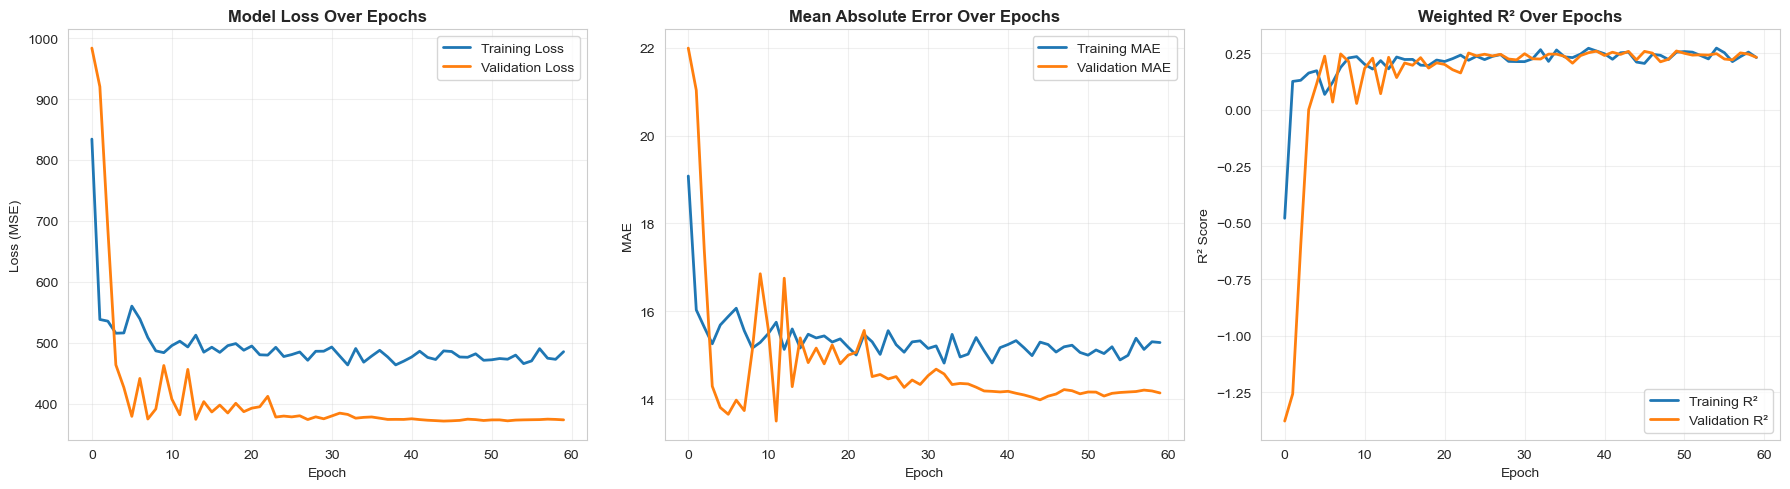


Best Validation Loss: 371.4435
Best Validation MAE: 13.5058
Best Validation R²: 0.2594


In [23]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Model Loss Over Epochs', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_title('Mean Absolute Error Over Epochs', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Weighted R²
axes[2].plot(history.history['weighted_r2'], label='Training R²', linewidth=2)
axes[2].plot(history.history['val_weighted_r2'], label='Validation R²', linewidth=2)
axes[2].set_title('Weighted R² Over Epochs', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('R² Score')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print best scores
print(f"\nBest Validation Loss: {min(history.history['val_loss']):.4f}")
print(f"Best Validation MAE: {min(history.history['val_mae']):.4f}")
print(f"Best Validation R²: {max(history.history['val_weighted_r2']):.4f}")

## 8. Evaluate Model on Validation Set

In [24]:
# Get predictions on validation set
val_predictions = model.predict(val_dataset)
val_true = val_data[TARGET_COLS].values

print("Validation Predictions Shape:", val_predictions.shape)
print("Validation True Values Shape:", val_true.shape)

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 401ms/step
Validation Predictions Shape: (72, 5)
Validation True Values Shape: (72, 5)
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 401ms/step
Validation Predictions Shape: (72, 5)
Validation True Values Shape: (72, 5)


In [25]:
# Calculate R² for each target
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

print("\n" + "="*60)
print("PER-TARGET VALIDATION METRICS")
print("="*60)

for idx, target in enumerate(TARGET_COLS):
    r2 = r2_score(val_true[:, idx], val_predictions[:, idx])
    mae = mean_absolute_error(val_true[:, idx], val_predictions[:, idx])
    rmse = np.sqrt(mean_squared_error(val_true[:, idx], val_predictions[:, idx]))
    
    print(f"\n{target}:")
    print(f"  R² Score: {r2:.4f}")
    print(f"  MAE: {mae:.4f}g")
    print(f"  RMSE: {rmse:.4f}g")
    print(f"  Weight in Competition: {WEIGHTS[target]}")


PER-TARGET VALIDATION METRICS

Dry_Green_g:
  R² Score: -0.0452
  MAE: 16.5100g
  RMSE: 22.1725g
  Weight in Competition: 0.1

Dry_Dead_g:
  R² Score: -0.0596
  MAE: 9.3853g
  RMSE: 12.3801g
  Weight in Competition: 0.1

Dry_Clover_g:
  R² Score: -0.0272
  MAE: 8.5792g
  RMSE: 13.5297g
  Weight in Competition: 0.1

GDM_g:
  R² Score: -0.0484
  MAE: 17.2727g
  RMSE: 22.4536g
  Weight in Competition: 0.2

Dry_Total_g:
  R² Score: -0.1038
  MAE: 20.1557g
  RMSE: 25.3507g
  Weight in Competition: 0.5


In [26]:
# Calculate global weighted R² (competition metric)
def calculate_weighted_r2(y_true, y_pred, weights_dict):
    """Calculate the competition's weighted R² metric"""
    # Flatten to create all (image, target) pairs
    n_samples = y_true.shape[0]
    n_targets = len(TARGET_COLS)
    
    # Create weight array for each sample-target pair
    weights_list = [weights_dict[col] for col in TARGET_COLS]
    weights_array = np.tile(weights_list, n_samples)
    
    # Flatten predictions and true values
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    # Calculate weighted mean
    weighted_mean = np.sum(y_true_flat * weights_array) / np.sum(weights_array)
    
    # Calculate SS_res and SS_tot
    ss_res = np.sum(weights_array * (y_true_flat - y_pred_flat) ** 2)
    ss_tot = np.sum(weights_array * (y_true_flat - weighted_mean) ** 2)
    
    # Calculate R²
    r2 = 1 - (ss_res / ss_tot)
    
    return r2

# Calculate competition metric
competition_r2 = calculate_weighted_r2(val_true, val_predictions, WEIGHTS)

print("\n" + "="*60)
print("COMPETITION METRIC (Weighted R²)")
print("="*60)
print(f"Global Weighted R²: {competition_r2:.6f}")
print("="*60)


COMPETITION METRIC (Weighted R²)
Global Weighted R²: 0.207838


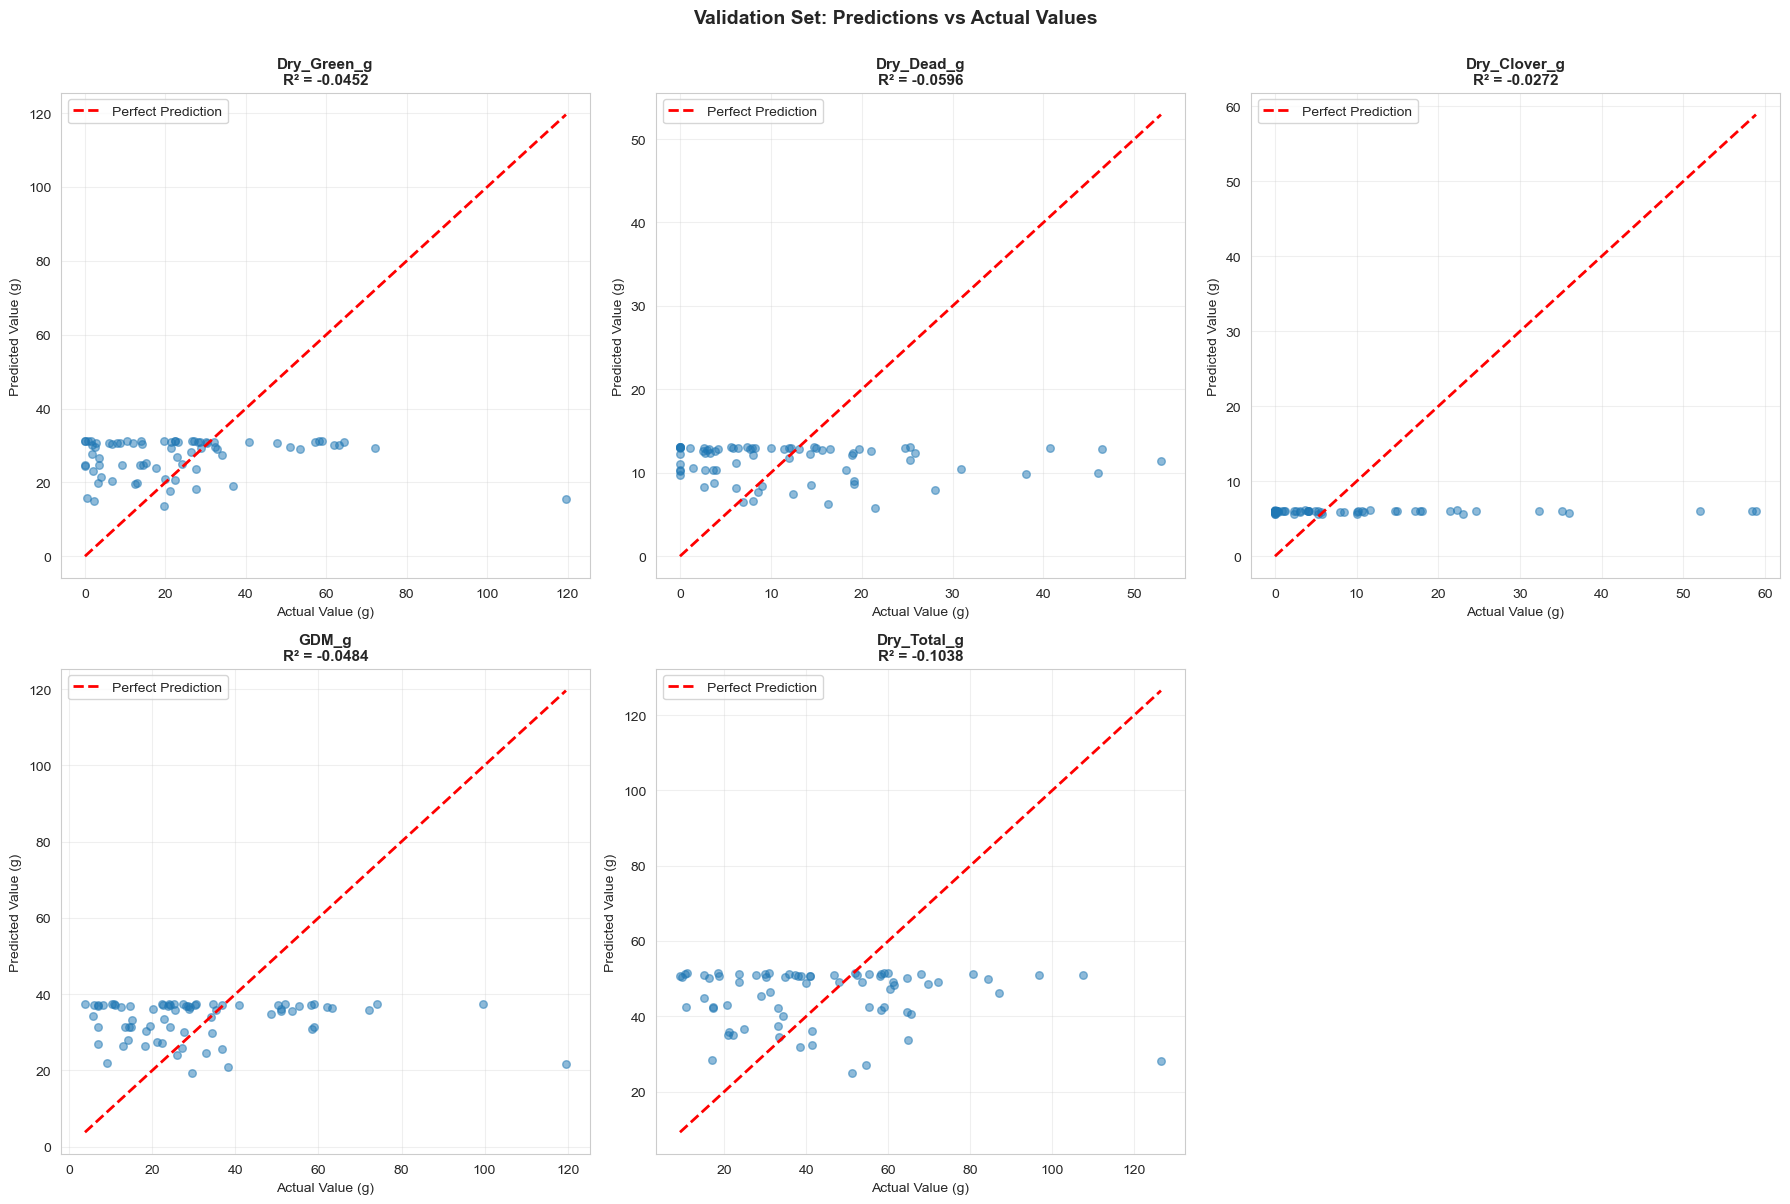

In [27]:
# Visualize predictions vs actual for each target
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, target in enumerate(TARGET_COLS):
    axes[idx].scatter(val_true[:, idx], val_predictions[:, idx], alpha=0.5, s=30)
    
    # Add diagonal line (perfect predictions)
    min_val = min(val_true[:, idx].min(), val_predictions[:, idx].min())
    max_val = max(val_true[:, idx].max(), val_predictions[:, idx].max())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    axes[idx].set_xlabel('Actual Value (g)', fontsize=10)
    axes[idx].set_ylabel('Predicted Value (g)', fontsize=10)
    axes[idx].set_title(f'{target}\nR² = {r2_score(val_true[:, idx], val_predictions[:, idx]):.4f}', 
                       fontsize=11, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

fig.delaxes(axes[5])
plt.suptitle('Validation Set: Predictions vs Actual Values', fontsize=14, fontweight='bold', y=1.0)
plt.tight_layout()
plt.show()

## 9. Generate Test Predictions and Submission File

In [28]:
# Extract unique image_ids from test data
test_df['image_id'] = test_df['image_path'].str.split('/').str[1].str.replace('.jpg', '')
test_image_ids = test_df['image_id'].unique()

print(f"Number of unique test images: {len(test_image_ids)}")
print(f"Test image IDs: {test_image_ids}")

# Create a simple dataframe with just image_ids for prediction
test_images_df = pd.DataFrame({'image_id': test_image_ids})

# Create test dataset
test_dataset = create_dataset(test_images_df, TEST_IMG_PATH, is_training=False)

# Generate predictions
print("\nGenerating predictions for test set...")
test_predictions = model.predict(test_dataset)

print(f"Test predictions shape: {test_predictions.shape}")
print(f"Number of test images: {len(test_images_df)}")
print(f"Predictions per image: {test_predictions.shape[1]}")

Number of unique test images: 1
Test image IDs: ['ID1001187975']

Generating predictions for test set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Test predictions shape: (1, 5)
Number of test images: 1
Predictions per image: 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Test predictions shape: (1, 5)
Number of test images: 1
Predictions per image: 5


In [29]:
# Create submission dataframe in required format
submission_data = []

for idx, image_id in enumerate(test_images_df['image_id']):
    for target_idx, target_name in enumerate(TARGET_COLS):
        sample_id = f"{image_id}__{target_name}"
        target_value = test_predictions[idx, target_idx]
        
        # Ensure non-negative predictions (biomass can't be negative)
        target_value = max(0, target_value)
        
        submission_data.append({
            'sample_id': sample_id,
            'target': target_value
        })

submission_df = pd.DataFrame(submission_data)

print("\nSubmission DataFrame:")
print(f"Shape: {submission_df.shape}")
print(f"Expected rows: {len(test_images_df) * 5}")
print("\nAll rows:")
print(submission_df)


Submission DataFrame:
Shape: (5, 2)
Expected rows: 5

All rows:
                    sample_id     target
0   ID1001187975__Dry_Green_g  30.974989
1    ID1001187975__Dry_Dead_g  12.957855
2  ID1001187975__Dry_Clover_g   6.034384
3         ID1001187975__GDM_g  37.384270
4   ID1001187975__Dry_Total_g  51.210087


In [30]:
# Verify submission format matches sample submission
print("\nVerifying submission format...")
print(f"Sample submission shape: {sample_sub.shape}")
print(f"Our submission shape: {submission_df.shape}")

# Check if all required sample_ids are present
sample_ids = set(sample_sub['sample_id'])
our_ids = set(submission_df['sample_id'])

if sample_ids == our_ids:
    print("✓ All sample_ids match!")
else:
    print("✗ Sample_ids mismatch!")
    missing = sample_ids - our_ids
    extra = our_ids - sample_ids
    if missing:
        print(f"  Missing IDs: {missing}")
    if extra:
        print(f"  Extra IDs: {extra}")

# Check column names
if list(submission_df.columns) == list(sample_sub.columns):
    print("✓ Column names match!")
else:
    print(f"✗ Column mismatch. Expected: {list(sample_sub.columns)}, Got: {list(submission_df.columns)}")


Verifying submission format...
Sample submission shape: (5, 2)
Our submission shape: (5, 2)
✓ All sample_ids match!
✓ Column names match!


In [31]:
# Save submission file
submission_path = os.path.join(DATA_PATH, 'submission.csv')
submission_df.to_csv(submission_path, index=False)

print(f"\n{'='*60}")
print(f"✓ Submission file saved to: {submission_path}")
print(f"{'='*60}")

# Display summary statistics of predictions
print("\nSubmission Statistics:")
print(submission_df['target'].describe())

print("\nPredictions by target type:")
for target in TARGET_COLS:
    target_preds = submission_df[submission_df['sample_id'].str.contains(target)]['target']
    print(f"\n{target}:")
    print(f"  Mean: {target_preds.mean():.2f}g")
    print(f"  Min: {target_preds.min():.2f}g")
    print(f"  Max: {target_preds.max():.2f}g")


✓ Submission file saved to: D:\ML Practice\CSIRO - Image2Biomass Prediction\CSIRO - Image2Biomass Prediction\submission.csv

Submission Statistics:
count     5.000000
mean     27.712317
std      18.330057
min       6.034384
25%      12.957855
50%      30.974989
75%      37.384270
max      51.210087
Name: target, dtype: float64

Predictions by target type:

Dry_Green_g:
  Mean: 30.97g
  Min: 30.97g
  Max: 30.97g

Dry_Dead_g:
  Mean: 12.96g
  Min: 12.96g
  Max: 12.96g

Dry_Clover_g:
  Mean: 6.03g
  Min: 6.03g
  Max: 6.03g

GDM_g:
  Mean: 37.38g
  Min: 37.38g
  Max: 37.38g

Dry_Total_g:
  Mean: 51.21g
  Min: 51.21g
  Max: 51.21g


## 10. Summary and Next Steps

### Model Architecture Summary

**Approach:**
- Multi-output regression CNN using EfficientNetB0 backbone (pretrained on ImageNet)
- Fine-tuned last 20 layers for pasture-specific features
- Custom regression head with dropout for regularization
- Simultaneous prediction of all 5 biomass targets

**Key Features:**
- Image size: 224x224 pixels
- Batch size: 16
- Optimizer: Adam with learning rate scheduling
- Loss function: Mean Squared Error (MSE)
- Custom weighted R² metric matching competition evaluation

### Potential Improvements

1. **Data Augmentation:**
   - Add rotation, flip, brightness adjustments
   - Color jittering to handle different lighting conditions
   - Crop variations to improve generalization

2. **Advanced Architectures:**
   - Try EfficientNetV2, ResNet, or Vision Transformers
   - Ensemble multiple models for better predictions
   - Add attention mechanisms to focus on vegetation

3. **Feature Engineering:**
   - Incorporate NDVI values if available as additional input
   - Extract texture features (GLCM)
   - Use multi-scale inputs

4. **Training Strategies:**
   - K-fold cross-validation for robust evaluation
   - Increase training data through augmentation
   - Experiment with different loss functions (Huber loss, custom weighted loss)

5. **Post-Processing:**
   - Enforce physical constraints (e.g., Dry_Total_g ≥ sum of components)
   - Apply domain knowledge about typical biomass ranges
   - Calibrate predictions based on validation set statistics

### Files Generated
- `submission.csv` - Ready for competition submission
- `best_biomass_model.h5` - Best performing model weights